In [1]:
import os
import sys 
import logging
import numpy as np
import torch as th
from matplotlib import pyplot as plt
from model import *
from utility import kb, amu, read_out_smooth, MultiCorr_t, th2np
from aigle import aigle
th.set_default_tensor_type(th.FloatTensor)

################## AIGLE parameters  ##################
base_params = {
    "comments"   : "CV:dipole; Int: 2rd nn; Onsite:4-th poly, free E;retrain GAR,  E=0 eq-train;  E=random noneq-train; direct-loss; boundary-loss; GAR no bias, noise include 2rdnn; impose simple 2fdt", 
    ## data params
    "efield"     : 0.0,
    "temp"       : 300,
    "md_dt"      : 0.002,
    "stride"     : 5,
    "smooth"     : 40,
    "block"      : 1,
    "nskip"      : 2,
    "relax_t"    : 5,       # the relaxation time from the constrained structure
    "window_x"   : 10,    # window size for training: x,y,z 
    "window_y"   : 10,    # window size for training: x,y,z 
    "window_z"   : 8,     # window size for training: x,y,z 
    "max_frames" : 2000, # maximal frames used for one batch
    ## model params 
    "onsite_only": True,
    "len_ag"     : 50,
    "lmem"       : 150,
    ## loading params
    "load"       : False,
    "load_path"  : "./g5s40b1ag50lmem150T300/stage0", 
    "load_label" : "10000",
    ## logging params
    "print_freq" : 1000, 
    "save_freq"  : 1000,  
    "profile"    : False, 
    "debug"      : False, 
    "langevin"   : 0,
}
base_params["dt"] = base_params["md_dt"] * base_params["stride"]
base_params["base_folder"] = 'g{}s{}b{}ag{}lmem{}T{}'.format(
    base_params["stride"],  base_params["smooth"], base_params["block"], base_params["len_ag"], 
    base_params["lmem"], base_params["temp"], )

################## Initialize working folders and logs ##################
if os.path.exists(base_params["base_folder"]) is False:
    os.mkdir(base_params["base_folder"])
logging.basicConfig(filename=os.path.join(base_params["base_folder"], 'train.log'),  level=logging.INFO)

#### print basic information
print('Working folder:', base_params["base_folder"])
print('Molecular dynamics data are collected at T={}K with time step {}ps'.format(base_params['temp'], base_params['md_dt']))
print('The CV trajectory will be smoothed with a Gaussian kernel and further coarse-grained to a time step of {}ps'.format(
    base_params["dt"]))
print('Time cutoff for memory kernel is {}ps'.format(base_params['lmem']*base_params["dt"]))
print('Time cutoff for noise generator is {}ps'.format(base_params['len_ag']*base_params["dt"]))

Working folder: g5s40b1ag50lmem150T300
Molecular dynamics data are collected at T=300K with time step 0.002ps
The CV trajectory will be smoothed with a Gaussian kernel and further coarse-grained to a time step of 0.01ps
Time cutoff for memory kernel is 1.5ps
Time cutoff for noise generator is 0.5ps


## Make train set of CV trajectories obtained from at-equilibrium MD simulation

In [2]:
################## model initialization    ##################
model_ext = poly_3Dsystem(lmem=base_params["lmem"],  onsite_only=base_params["onsite_only"] )
model_noise = FNN_noise_nnn( in_channels=base_params["len_ag"], onsite_only=base_params["onsite_only"] ) 
aigle_3d = aigle( base_params["temp"], dt=base_params["dt"], len_ag=base_params["len_ag"], lmem=base_params["lmem"], nskip=base_params["nskip"], 
        model_ext = model_ext, model_noise = model_noise  )
################## load equlibrium data    ##################
trainset = []
folder = './md_data/20X20X12T{:d}E{:.2f}'.format(base_params["temp"], base_params["efield"])  
traj = np.load(os.path.join(folder, 'dipole.npy'))
r,v,a = read_out_smooth( 
    traj, stride=base_params['stride'], le_dt=base_params['dt'], smooth = base_params['smooth'], 
    throw=int(base_params['relax_t'] / base_params['md_dt']), 
    block=base_params['block'])
del traj
trainset.append(
        {'r':r, 'v':v, 'a':a, 'e': np.zeros_like(r)+base_params['efield'],}  
        )
aigle_3d.v2_avg = (v**2).mean((0,1,2,4))
################## Equipartition    ##################
mass = kb * base_params["temp"] / aigle_3d.v2_avg   # 1/2mv^2 = 1/2kT,  ~12.6 meV/(eA/ps)^2
model_ext.ml = model_ext.ml*0 + mass[2]
model_ext.mt = model_ext.mt*0 + mass[0]
logging.info('Mass: longitudinal={}, transverse={}'.format(mass[2], mass[0]))
print('Loaded CV data obtained from MD simulation of a 20X20X12 supercell of PbTiO3. xy plane is epitaxially strained. The out-of-plane z-direction is free.')
print('Effective Mass for Euclidean components of local dipole: longitudinal (out-of-plane)={:.3f}, transverse={:.3f}'.format(mass[2], mass[0]))

Loaded CV data obtained from MD simulation of a 20X20X12 supercell of PbTiO3. xy plane is epitaxially strained. The out-of-plane z-direction is free.
Effective Mass for Euclidean components of local dipole: longitudinal (out-of-plane)=2.260, transverse=1.038


## Do force matching on equlibrium data. 

In [3]:
##################  Equlibrium Force matching parameters  ##################
fmatch_params = base_params.copy()
fmatch_params['model_folder'] = fmatch_params["base_folder"] + '/stage0'
## training params
fmatch_params['epoch'] = 15001
fmatch_params['lr'] = 0.1
fmatch_params['lr_decay'] = 0.95
fmatch_params['lr_window'] = 100

if os.path.exists(fmatch_params['model_folder']) is False:
    os.mkdir(fmatch_params['model_folder'])
    
if base_params["load"] is False:
    logging.info('============= Stage 0 : Matching force with equilibrium dataset: {}  ============='.format(folder))
    aigle_3d.force_match(  trainset,  fmatch_params )
else:
    logging.info('============= Stage 0 : Loading model from {}  ============='.format(base_params["load_path"]))
    aigle_3d.load_model(base_params["load_path"],label=base_params["load_label"],load_noise=False)


Text(0.5, 1.0, 'Onsite energy surface for out-of-plane dipole $d_z$')

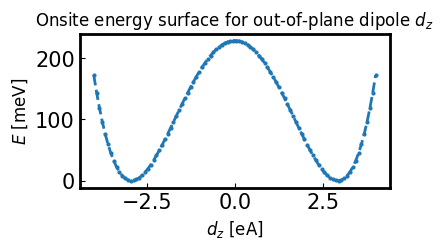

In [4]:
fig, ax= plt.subplots(figsize=(4,2))
dz = np.linspace(-4 , 4 ,100)
onsite_energy = [th2np(aigle_3d.model_ext.plot_meanfield_pot(x)) for x in dz]
onsite_energy = np.array(onsite_energy)
onsite_energy -= onsite_energy.min()
ax.plot( dz, onsite_energy )
ax.set_xlabel(r'$d_z$ [eA]')
ax.set_ylabel(r'$E$ [meV]')
ax.set_title('Onsite energy surface for out-of-plane dipole $d_z$')

## Learn memory kernel and noise generator from equlibrium data. 

### Direct calculation of memory kernel through least square 

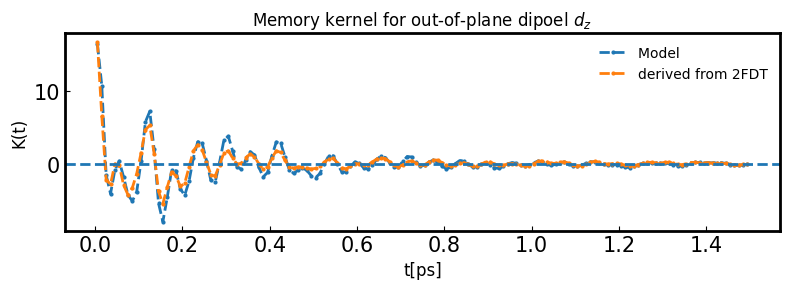

In [5]:
##################  Equlibrium Kernel&GAR  parameters  ##################
eq_params = base_params.copy()
eq_params["model_folder"] = eq_params["base_folder"] + '/stage1'
eq_params['kernel_epoch'] = 101
eq_params['epoch'] = 6001
eq_params['lr_GAR'] = 0.003
eq_params['lr_decay'] = 0.9
eq_params['lr_window'] = 100
eq_params['save_freq'] = 2000

if os.path.exists(eq_params['model_folder']) is False:
    os.mkdir(eq_params['model_folder'])
    
logging.info('============= Stage 1 :  Compute memory kernel with equilibrium dataset: {} ============='.format(folder))
aigle_3d.train_kernel(  trainset, eq_params )

#### plot memory kernel
model_ext = aigle_3d.model_ext
lmem = eq_params['lmem']
ktime = (np.arange(lmem)+0.5) * base_params["dt"]
fig, ax= plt.subplots(figsize=(8,3))
ax.plot(ktime, -model_ext.kosl, label='Model ' )
ax.plot(ktime,  -aigle_3d.kosl_fdt, label='derived from 2FDT' )
ax.axhline(y=0, xmin=0, xmax=lmem*base_params["dt"], markersize=0)
ax.set_xlabel('t[ps]')
ax.set_ylabel('K(t)')
ax.set_title(r'Memory kernel for out-of-plane dipoel $d_z$')
ax.legend()
plt.tight_layout()


### Training GAR model with time series of noise extracted from CV trajectoties

In [6]:
logging.info('============= Stage 1 :  Train GAR model with equilibrium dataset: {} ================'.format(folder))
aigle_3d.train_GAR(  trainset, eq_params )


### validation

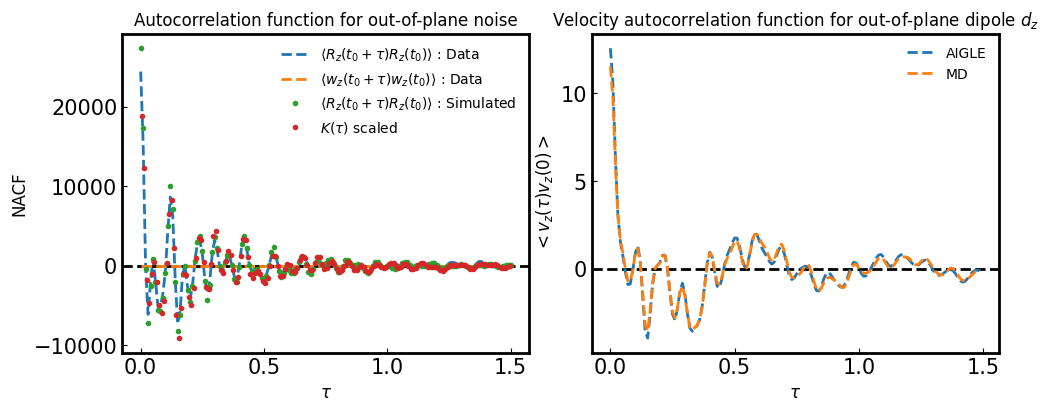

In [7]:
dev = aigle_3d.dev
lmem = aigle_3d.lmem
dt = aigle_3d.dt
params=eq_params
replicate=1
nbatch = 1
total_time=100
label='6000'
model_folder=eq_params['model_folder']
setidx=0
################## LOAD DATA  ###########################
nset =  len(trainset) 
# setidx = np.random.randint(nset)
nx, ny, nz, _ , nframes =  trainset[setidx]['r'].shape
beg = lmem
end = beg + lmem + max(aigle_3d.lmem+1, aigle_3d.len_ag+1) + 1
dataset={
    'r':      th.tensor(trainset[setidx]['r'][..., beg+lmem:end], dtype=th.float32, device=dev),
    'v':      th.tensor(trainset[setidx]['v'][..., beg+lmem:end], dtype=th.float32, device=dev),
    'a':      th.tensor(trainset[setidx]['a'][..., beg+lmem:end], dtype=th.float32, device=dev),
    'e':      th.tensor(trainset[setidx]['e'][..., beg+lmem:end], dtype=th.float32, device=dev),
    'v_more': th.tensor(trainset[setidx]['v'][..., beg+1:end], dtype=th.float32, device=dev),
}
dataset_full={
    'r':      th.tensor(trainset[setidx]['r'][..., beg+lmem:], dtype=th.float32, device=dev),
    'v':      th.tensor(trainset[setidx]['v'][..., beg+lmem:], dtype=th.float32, device=dev),
    'a':      th.tensor(trainset[setidx]['a'][..., beg+lmem:], dtype=th.float32, device=dev),
    'e':      th.tensor(trainset[setidx]['e'][..., beg+lmem:], dtype=th.float32, device=dev),
    'v_more': th.tensor(trainset[setidx]['v'][..., beg+1:], dtype=th.float32, device=dev),
}        
with th.no_grad():
    potential_energy = th2np(aigle_3d.model_ext.get_total_pot_components(dataset_full['e'], dataset_full['r']))  /nx/ny/nz  #(3,nframes)
    kinetic_energy = th2np( 0.5 * aigle_3d.model_ext.mass[:,None] * (dataset_full['v']**2).mean([0,1,2]) )  #(3,nframes)
potential_force, damp_force  = aigle_3d.model_ext( dataset['r'],  dataset['v_more'], dataset['e'] )
potential_force = potential_force.detach() 
damp_force = damp_force.detach()
a_pred =  potential_force + damp_force
a_ref = dataset['a']
noise = a_ref - a_pred
with th.no_grad():
    noise_pred, noise_ref, noise_sigma = aigle_3d.get_noise(dataset['r'], noise.detach() )  ##  (nx, ny, nframes-lmem)
    white_noise = noise_ref - noise_pred
################## Reference correlation  ###########################
corr_xx_spatial = []
for dd in range(nz//2 -1):
    _corr = (th.roll(dataset['r'], dd, 2)  *  dataset['r']).mean()
    corr_xx_spatial.append(th2np(_corr))
######################  SIMULATE #########################
relax_steps = max(aigle_3d.lmem+1, aigle_3d.len_ag+1)
r_list = [dataset['r'][...,[i]].repeat(replicate,replicate,1,1, nbatch) for i in range(relax_steps) ]
v_list = [dataset['v'][...,[i]].repeat(replicate,replicate,1,1, nbatch) for i in range(relax_steps) ]
n_list = [noise[...,[i]].repeat(replicate,replicate,1,1,nbatch) for i in range(relax_steps)]
efield = dataset['e'][...,[0]].repeat(replicate,replicate,1,1,nbatch) 
efield_scalar = th2np(dataset['e'][...,2,0]).mean()
total_steps = int(total_time / dt)
aigle_3d.sim_init(r_list, v_list,n_list)
for step in range(total_steps - relax_steps):
    if params['langevin']:
        ## Langevin dynamics
        damping = np.abs( th2np(aigle_3d.model_ext.kos_long).sum())
        E_pot, E_kin = aigle_3d.langevin_step(efield, damping)
    else:
        #AIGLE dynamics
        pforce, vforce, E_pot, E_kin = aigle_3d.sim_step(efield, pop=False)

# ######################  Simulated correlation #########################
_m = th.ones_like(aigle_3d.r_list[-1][:,:,:,0,0]).to(dtype=bool)
aigle_3d.r_list = th.cat([ x.unsqueeze(-1) for x in aigle_3d.r_list], -1)   #(nx,ny,nz,3,nbatch, nframes)
aigle_3d.v_list = th.cat([ x.unsqueeze(-1) for x in aigle_3d.v_list], -1)
aigle_3d.n_list = th.cat([ x.unsqueeze(-1) for x in aigle_3d.n_list], -1)
roll_axis = 2
corr_nn_sim  = MultiCorr_t( aigle_3d.n_list[_m],aigle_3d.n_list[_m], lmem+1, axis=[0,2,3])
corr_nnl_sim = MultiCorr_t( th.roll(aigle_3d.n_list, 1, roll_axis)[_m], aigle_3d.n_list[_m], lmem+1, axis=[0,2,3]   )
corr_nnt_sim = MultiCorr_t( th.roll(aigle_3d.n_list, 1, 0)[_m], aigle_3d.n_list[_m], lmem+1, axis=[0,2,3]   )
corr_nnlt_sim = MultiCorr_t( th.roll(th.roll(aigle_3d.n_list, 1, roll_axis),1,0)[_m], aigle_3d.n_list[_m], lmem+1, axis=[0,2,3])
corr_nnll_sim = MultiCorr_t(  th.roll(aigle_3d.n_list, 2, roll_axis)[_m], aigle_3d.n_list[_m], lmem+1, axis=[0,2,3])

corr_vv_sim = MultiCorr_t( aigle_3d.v_list[_m], aigle_3d.v_list[_m], lmem, axis=[0,2,3])
corr_vvlt_sim = MultiCorr_t( th.roll(th.roll(aigle_3d.v_list, 1, roll_axis),1,0)[_m] , aigle_3d.v_list[_m], lmem, axis=[0,2,3])
corr_vvl_sim = MultiCorr_t( th.roll(aigle_3d.v_list,1, roll_axis)[_m] , aigle_3d.v_list[_m], lmem, axis=[0,2,3]) 
corr_vvll_sim = MultiCorr_t( th.roll(aigle_3d.v_list,2, roll_axis)[_m] , aigle_3d.v_list[_m], lmem, axis=[0,2,3]) 

## update the kernel from 2FDT that better preserve 2FDT during simulation
aigle_3d.kosl_infer = aigle_3d.get_simple_kernal( G=aigle_3d.v2_avg[2], Gp=corr_vvlt_sim[0,2]/corr_vv_sim[0,2]*aigle_3d.v2_avg[2], 
                                            rho=corr_nn_sim[:,2], rhop=corr_nnlt_sim[:,2], e1=8) * dt
aigle_3d.kosl_infer = (aigle_3d.kosl_infer[:-1] + aigle_3d.kosl_infer[1:]) / 2
################## plot color/white noise autocorrelation  ##################
figa, ax = plt.subplots(1,2, figsize = (10, 4))
main_axis = 2
ax[0].axhline(y=0, color='black', markersize=0)
if aigle_3d.corr_dict_z is not None:
    ax[0].plot(
        np.arange( aigle_3d.corr_dict_z['corr_nn'].size )* dt, 
        aigle_3d.corr_dict_z['corr_nn'], 
        label=r'$\langle R_z(t_0+\tau)R_z(t_0)\rangle$ : Data', markersize = 0, linewidth=2)
    ax[0].plot(
        np.arange( aigle_3d.corr_dict_z['corr_ww'].size )* dt, 
        aigle_3d.corr_dict_z['corr_ww'], 
        label=r'$\langle w_z(t_0+\tau)w_z(t_0)\rangle$ : Data', markersize = 0, linewidth=2)
    ax[0].plot(
        np.arange( corr_nn_sim[:,main_axis].size )* dt, 
        corr_nn_sim[:,main_axis], 
        label=r'$\langle R_z(t_0+\tau)R_z(t_0)\rangle$ : Simulated', markersize = 3, linestyle='solid', linewidth=0)
    ax[0].plot(
        (np.arange(aigle_3d.model_ext.kosl.size)+0.5)* dt,
         - aigle_3d.model_ext.kosl/aigle_3d.dt * aigle_3d.v2_avg[-1],
        label=r'$K(\tau)$ scaled', markersize = 3, linestyle='solid', linewidth=0
    )

ax[0].set_xlabel(r'$\tau$')
ax[0].set_ylabel('NACF')
ax[0].legend(fontsize=10 )
ax[0].set_title(r'Autocorrelation function for out-of-plane noise')

###### plot velocity autocorrelation
ax[1].axhline(y=0, color='black', markersize=0)
ax[1].plot(
    np.arange( corr_vv_sim[:,main_axis].size )* dt, 
    corr_vv_sim[:,main_axis], 
    label='AIGLE', markersize = 0, linewidth=2)

if aigle_3d.corr_dict_z is not None:
    ax[1].plot(
        np.arange( aigle_3d.corr_dict_z['corr_vv'].size )* dt, 
        aigle_3d.corr_dict_z['corr_vv'], 
        label='MD', markersize = 0, linewidth=2)

ax[1].set_xlabel(r'$\tau$')
ax[1].set_ylabel(r'$<v_z(\tau)v_z(0)>$')
ax[1].set_title(r'Velocity autocorrelation function for out-of-plane dipole $d_z$')
ax[1].legend(fontsize=10)

figa.tight_layout(pad=0.3)


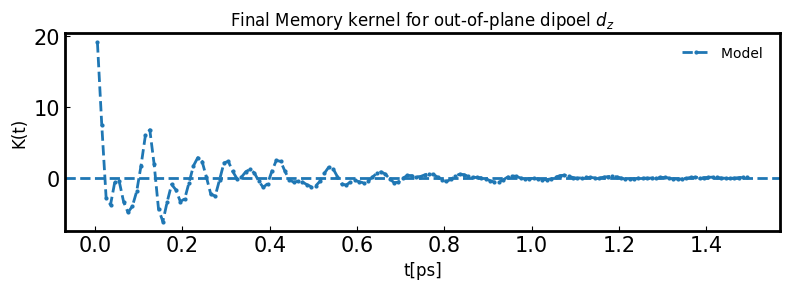

In [8]:
logging.info('============= Stage 1 :  Reinforce 2FDT  ================' )
aigle_3d.model_ext.kosl = aigle_3d.kosl_infer
logging.info('K_osl(t): {}'.format(aigle_3d.model_ext.kosl))
#### plot memory kernel
model_ext = aigle_3d.model_ext
lmem = eq_params['lmem']
ktime = (np.arange(lmem)+0.5) * base_params["dt"]
fig, ax= plt.subplots(figsize=(8,3))
ax.plot(ktime, -model_ext.kosl, label='Model ' )
ax.axhline(y=0, xmin=0, xmax=lmem*base_params["dt"], markersize=0)
ax.set_xlabel('t[ps]')
ax.set_ylabel('K(t)')
ax.set_title(r'Final Memory kernel for out-of-plane dipoel $d_z$')
ax.legend()
plt.tight_layout()

## Do force matching on non-equlibrium data. 


In [9]:
##################  Non-Equlibrium Force matching parameters  ##################
noneq_params = base_params.copy()
noneq_params["model_folder"] = noneq_params["base_folder"] + '/stage2'
noneq_params['relax_t'] = 1
noneq_params['window_x'] = 50
noneq_params['window_y'] = 50
noneq_params['window_z'] = 6
noneq_params['max_frames'] = 500
noneq_params['epoch'] = 10001
noneq_params['save_freq'] = 2000
noneq_params['lr'] = 0.1
noneq_params['lr_decay'] = 0.95
noneq_params['lr_window'] = 100
if os.path.exists(noneq_params['model_folder']) is False:
    os.mkdir(noneq_params['model_folder'])

##################### LOAD non-equlibrium data  ##################
efield_list = [ 0.5, 1.0]
for efield in efield_list:
    folder = './md_data/50X50X12T{}E{:.2f}'.format( noneq_params["temp"], efield)
    traj = np.load(os.path.join(folder, 'dipole.npy'))
    r,v,a = read_out_smooth( 
        traj, stride=noneq_params['stride'], le_dt=noneq_params['dt'], smooth = noneq_params['smooth'], 
        throw=int(noneq_params['relax_t'] / noneq_params['md_dt']), 
        block=noneq_params['block'])
    del traj
    trainset.append(
            {'r':r, 'v':v, 'a':a, 'e': np.zeros_like(r)+np.array([0,0,efield])[None,None,None,:,None] }
            )
    logging.info('loaded {}, traj shape={}'.format(folder, r.shape))
logging.info('============= Stage 2: Matching force with non-equilibrium dataset  =============' )
aigle_3d.force_match(  trainset,  noneq_params, noneq=True )

Text(0.5, 1.0, 'Final onsite energy surface for out-of-plane dipole $d_z$')

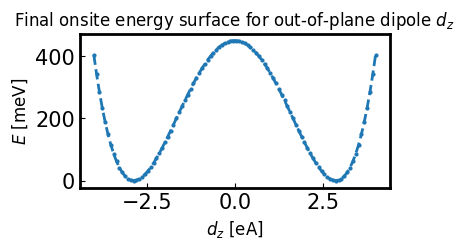

In [10]:
fig, ax= plt.subplots(figsize=(4,2))
dz = np.linspace(-4 , 4 ,100)
onsite_energy = [th2np(aigle_3d.model_ext.plot_meanfield_pot(x)) for x in dz]
onsite_energy = np.array(onsite_energy)
onsite_energy -= onsite_energy.min()
ax.plot( dz, onsite_energy )
ax.set_xlabel(r'$d_z$ [eA]')
ax.set_ylabel(r'$E$ [meV]')
ax.set_title('Final onsite energy surface for out-of-plane dipole $d_z$')